# Julia Webexperiment Aggregated Data Analysis

In [1]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('dortmund-data-r.csv', sep=';')
df = df[[
    'id', 'subject_group', 'token', 'answer_values', 'element_id',
    'hidden_figure', 'hidden_inference', 'hidden_maximum', 'hidden_minimum'
]]

df = df.drop(['subject_group', 'hidden_maximum', 'hidden_minimum'], axis=1)

# Extract all conditional tasks (start with 'agree')
# This still contains numerical agreement values
df['task'] = df['element_id'].apply(lambda x: True if x.startswith('agree') else False)
task_df = df.loc[df['task']].copy()

### Split the dataset into yes/no/unknown and interaval data

In [83]:
# Extract all yes-no-unknown tasks
# This filters out numerical agreement values
def infer_binary(x):
    if x in ['yes', 'no', 'unknown']:
        return True
    return False
task_df['binary'] = task_df['answer_values'].apply(infer_binary)

binary_df = task_df.loc[task_df['binary']].drop('binary', axis=1)

interval_df = task_df.loc[task_df['binary'] == False].drop('binary', axis=1)
interval_df = interval_df.drop(['id', 'element_id', 'task'], axis=1)

# Sanity checks
print('----- Sanity check -----')
print('No. binary tokens:', len(binary_df['token'].unique()))
print('No. interval tokens:', len(interval_df['token'].unique()))

----- Sanity check -----
No. binary tokens: 51
No. interval tokens: 98


### Cast the yes/no/unknown to 1/0

In [84]:
# Binary data evaluation
def binary_correctness(x):
    if x.lower() == 'yes':
        return 1
    return 0
binary_df['correctness'] = binary_df['answer_values'].apply(binary_correctness)
binary_df = binary_df.drop(['id', 'answer_values', 'task', 'element_id'], axis=1)

In [112]:
correct_number_responses = binary_df['token'].value_counts()

# Count tokens
individuals = binary_df.join(correct_number_responses, on='token', how='left', rsuffix='_number')
# Drop participants who did not answer all questions
individuals = individuals[individuals.token_number == 36]

individuals = individuals.groupby(['token', 'hidden_inference', 'hidden_figure'], as_index=False)['correctness'].agg('sum')
individuals = individuals[individuals.hidden_inference == 'Deduction']
individuals = individuals.pivot(index='token', columns='hidden_figure', values='correctness')

display(individuals.iloc[0:5])

AttributeError: 'Index' object has no attribute 'droplevel'

### Aggregate Data: Binary Acceptance

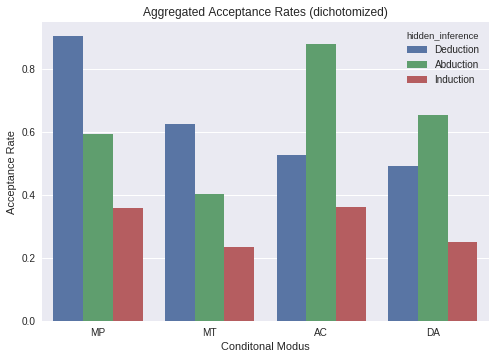

In [4]:
binary_agg = binary_df.groupby(['hidden_inference', 'hidden_figure'], as_index=False)['correctness'].agg('mean')

# Create aggregated table
table_data = []
for info, info_df in binary_agg.groupby('hidden_inference'):
    table_data.append({
        'type': info,
        'MP': info_df.loc[info_df['hidden_figure'] == 'MP']['correctness'].values[0],
        'MT': info_df.loc[info_df['hidden_figure'] == 'MT']['correctness'].values[0],
        'AC': info_df.loc[info_df['hidden_figure'] == 'AC']['correctness'].values[0],
        'DA': info_df.loc[info_df['hidden_figure'] == 'DA']['correctness'].values[0]
    })
table_df = pd.DataFrame(table_data)[['type', 'MP', 'MT', 'DA', 'AC']]
#print('Aggregated answer rates (binary tasks):')
#print(table_df)

#display(binary_agg)

b = sns.barplot(x='hidden_figure', y='correctness', hue='hidden_inference',
               data=binary_agg, order=['MP', 'MT', 'AC', 'DA'], 
               hue_order=['Deduction', 'Abduction', 'Induction'])
b.set_title('Aggregated Acceptance Rates (dichotomized)')
b.set_ylabel('Acceptance Rate')
b.set_xlabel('Conditonal Modus')
plt.show()

### Aggregate Data: Acceptance Intervals

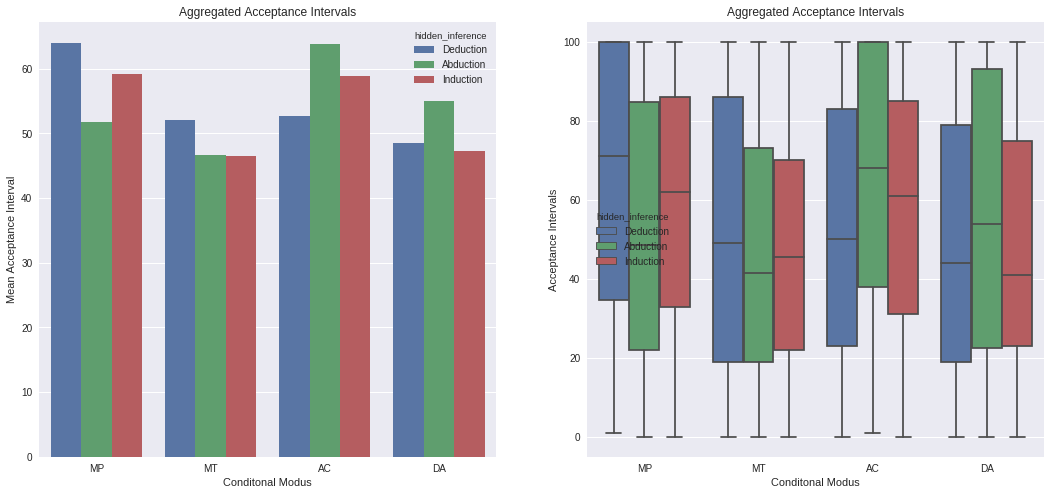

In [5]:
interval_df['answer_values'] = interval_df['answer_values'].apply(pd.to_numeric)
interval_agg = interval_df.groupby(['hidden_inference', 'hidden_figure'], as_index=False)['answer_values'].agg('mean')
#display(interval_agg)

fig, ax = plt.subplots(1, 2, figsize=(18, 8))
i = sns.barplot(x='hidden_figure', y='answer_values', hue='hidden_inference', ax=ax[0],
                data=interval_agg, order=['MP', 'MT', 'AC', 'DA'], 
                hue_order=['Deduction', 'Abduction', 'Induction'])
i.set_title('Aggregated Acceptance Intervals')
i.set_ylabel('Mean Acceptance Interval')
i.set_xlabel('Conditonal Modus')

box = sns.boxplot(x='hidden_figure', y='answer_values', hue='hidden_inference', ax=ax[1],
                  data=interval_df, order=['MP', 'MT', 'AC', 'DA'],
                  hue_order=['Deduction', 'Abduction', 'Induction'])
box.set_title('Aggregated Acceptance Intervals')
box.set_ylabel('Acceptance Intervals')
box.set_xlabel('Conditonal Modus')
plt.show()

### Create individual patterns
* If a participant sais Yes 2 or 3 times, this is Acceptance
* Everything else is Rejection
* If the participant did not answer 4 times for every condition (Ded, In, Ab), discard her

ERROR: Invalid number of responses for DiYeTV3-Abduction (3)
ERROR: Invalid number of responses for DiYeTV3-Deduction (2)
ERROR: Invalid number of responses for c5yYtX7-Abduction (1)
ERROR: Invalid number of responses for c5yYtX7-Induction (1)


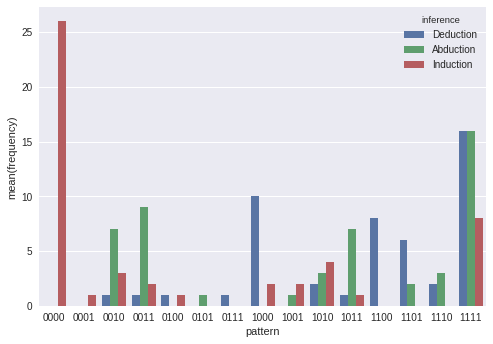

In [8]:
# Create the individual patterns
binary_agg_df = binary_df.groupby(['token', 'hidden_inference', 'hidden_figure'], as_index=False).agg('mean')
binary_agg_df['correctness'] = binary_agg_df['correctness'].apply(lambda x: x > 0.6)

pattern_data = []
for info, info_df in binary_agg_df.groupby(['token', 'hidden_inference']):
    if len(info_df) != 4:
        print('ERROR: Invalid number of responses for {}-{} ({})'.format(
            info[0], info[1], len(info_df)))
        continue

    pattern_data.append({
        'token': info[0],
        'inference': info[1],
        'MP': info_df.loc[info_df['hidden_figure'] == 'MP']['correctness'].values[0],
        'MT': info_df.loc[info_df['hidden_figure'] == 'MT']['correctness'].values[0],
        'AC': info_df.loc[info_df['hidden_figure'] == 'AC']['correctness'].values[0],
        'DA': info_df.loc[info_df['hidden_figure'] == 'DA']['correctness'].values[0]
    })

pattern_df = pd.DataFrame(pattern_data)
pattern_df['pattern'] = pattern_df[['MP', 'MT', 'AC', 'DA']].apply(
    lambda x: ''.join([str(int(y)) for y in x]), axis=1)

pattern_df['frequency'] = 1
pattern_frequency_df = pattern_df.groupby(['inference', 'pattern'], as_index=False)['frequency'].agg('count')

#display(pattern_frequency_df)

box = sns.barplot(x='pattern', y='frequency', hue='inference',
                  data=pattern_frequency_df,
                  hue_order=['Deduction', 'Abduction', 'Induction'])
plt.show()